In [1]:
%load_ext lab_black
import numpy as np
import cv2
from supermariopy import plotting

plotting.set_style()
from matplotlib import pyplot as plt

# Define Image Files

True

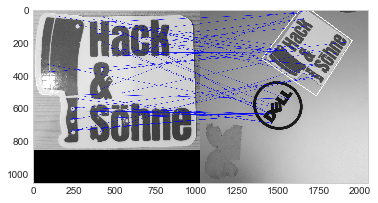

In [3]:
img_path1 = "template.jpg"
img_path2 = "scene.jpg"

MIN_MATCH_COUNT = 10

img1 = cv2.imread(img_path1, 0)  # queryImage
img2 = cv2.imread(img_path2, 0)  # trainImage

sift = cv2.xfeatures2d.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)

flann = cv2.FlannBasedMatcher(index_params, search_params)

matches = flann.knnMatch(des1, des2, k=2)

# store all the good matches as per Lowe's ratio test.
good = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        good.append(m)


if len(good) > MIN_MATCH_COUNT:
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)

    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    matchesMask = mask.ravel().tolist()

    h, w = img1.shape
    pts = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)
    dst = cv2.perspectiveTransform(pts, M)

    img2 = cv2.polylines(img2, [np.int32(dst)], True, 255, 3, cv2.LINE_AA)

else:
    print(
        "Not enough matches are found - {:02d}/{:02d}".format(
            len(good), MIN_MATCH_COUNT
        )
    )
    matchesMask = None

# Draw inliers and outliers

draw_params = dict(
    matchColor=(0, 255, 0),  # draw matches in green color
    singlePointColor=(0, 255, 0),
    matchesMask=matchesMask,  # draw only inliers
    flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS,
)

img3 = cv2.drawMatches(img1, kp1, img2, kp2, good, None, **draw_params,)

plt.imshow(img3)
cv2.imwrite("inlier_matches.png", img3)

outlier_mask = list(np.logical_not(np.array(matchesMask) == 1) * 1.0)

draw_params = dict(
    matchColor=(0, 0, 255),  # draw matches in green color
    singlePointColor=None,
    matchesMask=outlier_mask,  # draw only inliers
    flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS,
)

img3 = cv2.drawMatches(img1, kp1, img2, kp2, good, None, **draw_params)

plt.imshow(img3)
plt.grid(False)
cv2.imwrite("outlier_matches.png", img3)